# Multilayer Perceptron

**Prerequisites**

- Tensorflow
- SGD

**Outcomes**

- Understand the core concepts behind the Multilayer Perceptron model
- Understand the importance of activation functions
- Be able to select different output activations for different ML tasks
- Be able to define and fit MLP using keras

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("seaborn")

import tensorflow as tf
import pandas as pd

## Brief Detour: Function Composition

- Consider the expression: $$\hat{y} = f_3(f_2(f_1(x)))$$
- This is a *nested* or *recursive* application of functions $f_1$, $f_2$, and $f_3$
- A little cumbersome because of all the parenthesis

### Function Composition Notation

- Alternative notation: $$y = (f_3 \circ f_2 \circ f_1) (x)$$
- This is called *function composition*
- Meaning is the same as before:
    - Evaluate $f_1(x)$
    - Feed output into $f_2$
    - Feed that output into $f_3$

### Comparison in Code

- The simplification also carries over into code:

```python
# nested/recursive form
y = f3(f2(f1(x)))

# composition
fs = [f1, f2, f3]
y = x
for f in fs:
    y = f(y)
```
- In the composition case we can easiliy apply many functions by adding to list `fs`
- Will come up later...

## Neurons and the MLP model

- We will now learn what is meant by "neural" in "neural networks"
- There are three perspectives from which we will look at this model:
    1. Visually
    2. Mathematically
    3. In Code
- We'll work through the perspectives in this order
- Reccomendation: focus on the perspective that makes the most sense to you!

### Visual Perspective

- Neural networks are built from neurons
- But what are they?
- Borrow from biology and attempt to mimic the way our brains work

![biology.png](biology.png)

### Layers of Neurons

- The neuron is also called a perceptron
- The multi-layer perceptron extends the notion of connecting a network of neurons to one another:
    - Neurons are stacked on top of one another in a *layer*
    - Layers are stacked in sequence, one after another

![MLP.png](MLP.png)

### Mathematical Perspective

- Each neuron in layer $l$ is connected to all neurons in layer $l-1$
- Mathematical interpretation of the visuals:
    - Squares are input features $x$
    - Red circles are numbers (hidden neurons)
    - Pink circles are outputs
    - Arrows are elements of weight matrix $W$


### Each Layer is a Linear Regression

- Meaning: multilayer perceptron is nested linear regression, separated by non-linear activation function: $$y = f_{\text{out}}(W_L f_{\cdots} \left(W_{\cdots} f_2(W_2 f_1(W_1 X + b_1) + b_2)  + b_{\cdots} \right) + b_{L})$$
- that's scary looking... 
- we'll clean up the notation

### MLP Notation: Activations

$$\begin{aligned}
y &= f_{\text{out}}\left(W_L f_{\cdots} \left(W_{\cdots} f_2(W_2 \underbrace{f_1(W_1 X + b_1)}_{\triangleq a_1} + b_2)  + b_{\cdots} \right) + b_{L} \right) \\
  &= f_{\text{out}}\left(W_L f_{\cdots} \left(W_{\cdots} \underbrace{f_2(W_2 a_1 + b_2)}_{\triangleq a_2}  + b_{\cdots} \right) + b_{L} \right) \\
  &= f_{\text{out}}\left(W_L f_{\cdots} \left(W_{\cdots} {a_2}  + b_{\cdots} \right) + b_{L} \right)
\end{aligned}$$

- Notice pattern: $a_{l} = f_l(W_l a_{l-1} + b_l)$
- These $a_{l}$ are the outputs of layer $l$

### MLP Notation: Function Composition

- Let $D_l(x; W_l, b_l) = W_l x + b_l$ -- shorthand $D_l$ (look familiar?!)
- Let $f_l$ be *activation function* for layer $l$ (more detail soon)
- Write MLP using function composition notation: $$y = (f_{\text{out}} \circ D_L \circ f_{L-1} \circ D_{L-1} \circ \cdots f_1 \circ D_1)(x)$$

### Code Perspective

- In tensorflow, we use the `keras` submodule to describe our MLP
- The perceptron layer is defined as `keras.layers.Dense` (because the connections from one layer to the next are dense)
- The keras code uses `keras.Sequential` and most closely follows the function composition notation from above
- For example:

In [2]:
example_model = tf.keras.Sequential([
    tf.keras.layers.Dense(12, input_dim=10),  # len(x) == 10, 12 neurons in layer 1
    tf.keras.layers.Dense(20),                # 20 neurons in layer 2
    tf.keras.layers.Dense(10),                # 10 neurons in layer 3
    tf.keras.layers.Dense(1)                  # one output
])
example_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                132       
                                                                 
 dense_1 (Dense)             (None, 20)                260       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 613
Trainable params: 613
Non-trainable params: 0
_________________________________________________________________


We will see many more examples of the "code perspective" as we build and train MLPs

## Activation Functions

- Let's focus on the funcitons $f_l$ where $l=1, \cdots L$
- These are called activation functions
- Key features:
    - Nonlinear: allow MLP to model nonlinear relationships between $X$ and $y$
    - Control range: modify output space for each layer
    - Differentiable: allows training with gradient descent

### Common Activations

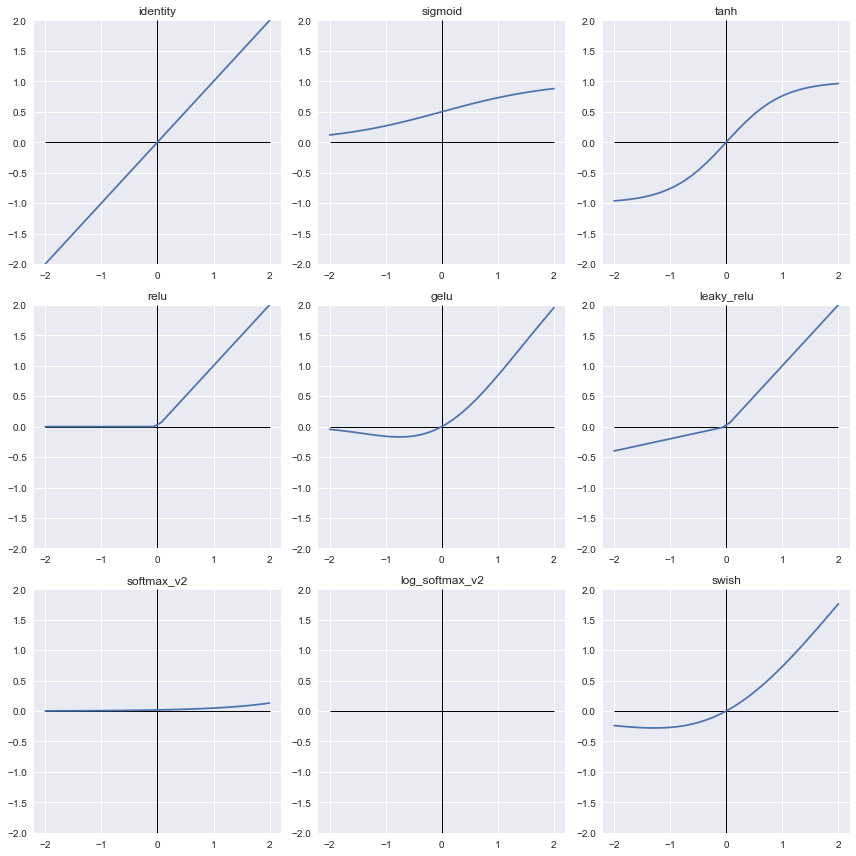

In [3]:
import tensorflow as tf

x = tf.linspace(-2, 2, 30)

def identity(x):
    return x

activations = np.array([
    [identity, tf.nn.sigmoid, tf.nn.tanh],
    [tf.nn.relu, tf.nn.gelu, tf.nn.leaky_relu], 
    [tf.nn.softmax, tf.nn.log_softmax, tf.nn.silu],
])

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        f = activations[i, j] 
        ax = axs[i, j]
        ax.plot(x, f(x))
        ax.set_title(f.__name__)
        ax.hlines(0, -2, 2, "k", lw=1)
        ax.vlines(0, -2, 2, "k", lw=1)
        ax.set_ylim(-2,2)

fig.tight_layout();

### So many choices!

- There are *many* choices for what activation to choose
- Our suggestion: use ReLU unless the context/model/application argues strongly that you use something else

## Output Activations

- We have seen that we can use the MLP model for regression tasks
- We can also use MLP for other settings
- The key is to choose the output activation to target the proper range
- The table below summarizes a few options

| Problem                    | $Y$               | activation | output range                           |
|----------------------------|-------------------|------------|----------------------------------------|
| regression                 | $\mathbb{R}^M$    | identity   | $(-\infty, \infty)^M$                  |
| binary classification      | $\{0, 1\}$        | sigmoid    | $(0, 1)$                               |
| multinomial classification | $\{0, \dots, K\}$ | softmax    | $(0,1)^K \; \text{and} \sum \cdot = 1$ |
| multilabel classification  | $\{0, 1\}^K$ | sigmoid    | $(0, 1)^K$                             |

### Example: Recognizing Digits

- Let's see how our MLP can be used for multinomial classification
- The classic benchmark problem is handwriting recognition for handwritten digits
- The dataset is known as MNIST and is referenced extensively in tutorials and other parts of the literature
- Tensorflow has built in functions to load this data for us:

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11501568/11490434 [==============================] - 1s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


#### Data

- The data is organized in 4 dimensions: (observation, pixel_x, pixel_y, color_channel)

In [5]:
x_train.shape

(60000, 28, 28, 1)

- In training dataset we have 60,000 observations of 28x28 grayscale images
- We only have one color channel on a scale from 0 to 1 where 0 is white and 1 is black

#### Visualizing the data

Matplotlib can help us visualize some of the observations

In [6]:
np.set_printoptions(linewidth=220, precision=1, suppress=True)
x_train[0, :, :, 0]

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.1, 0.1, 0.5, 0.5, 0.7, 0.1, 0.7, 1. , 1. , 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.1, 0.4, 0.6, 0.7, 1. , 1. , 1. , 1. , 1. , 0.9, 0.7

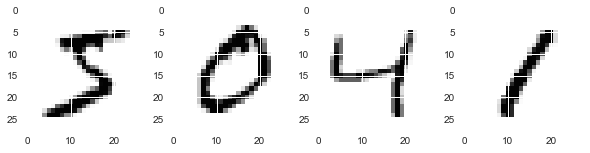

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(10, 6))
for i in range(4):
    ax[i].imshow(x_train[i, :, :, 0])

#### Activation for Multiclass Classification

- Goal: build an MLP that can label which digit is written
- There are 10 digits (0, 1, ..., 9)
- This is a multiclass classification problem
- Output of model: probability distribution over 10 digits
    - 10 element vector
    - All elements between (0, 1)
    - Elements sum to 1
- Softmax activation function gives us this: $$\text{softmax}(z)_i = \frac{e^{z_i}}{\sum_{k=1}^{N} e^{z_k}}$$

#### The right loss function

- We've typically used the MSE as the loss function
- This is appropriate for regression settings where outputs are continuous and we want to get as close to targets as possible
- In our multi-class classification problem we want to penalize any incorrect answer
- The most common loss function used in this setting is called the *sparse categorical cross entropy* loss function:
$$l(y_i, \hat{y}_i) = - \sum_{m=0}^9 \mathbf{1}_{y_i = m} log(\hat{y}_{i,m})$$

#### Intuition on loss function

- $\hat{y}_{i,m} \in (0,1)$ tells probability with which model believes $X_i$ is digit $m$
- $log(\hat{y}_{i,m}) \in (-\infty, 0)$ is very large negative when $y_{i,m}$ close to zero, but approaaches $0$ as $y_{i,m} \rightarrow 1$
- Multiplying by $\mathbf{1}_{y_i = m}$ focuses loss only on degree of incorrectness for the actual digit for this sample

#### MLP for Multiclass Classification

- We are now ready to build our image classifier!

In [8]:
x_train.shape[0] // 32

1875

In [9]:
# 1. define model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation="softmax")
])

# 2 compile model (choose optimizer and loss)
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# 3. train model
history = model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_test, y_test),
)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2519 - sparse_categorical_accuracy: 0.9270 - val_loss: 0.1400 - val_sparse_categorical_accuracy: 0.9568
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1168 - sparse_categorical_accuracy: 0.9655 - val_loss: 0.0956 - val_sparse_categorical_accuracy: 0.9717
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0862 - sparse_categorical_accuracy: 0.9749 - val_loss: 0.0965 - val_sparse_categorical_accuracy: 0.9713
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0700 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.0894 - val_sparse_categorical_accuracy: 0.9755
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0598 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.0849 - val_sparse_categorical_accuracy: 0.9766
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0506 - spar

<AxesSubplot:>

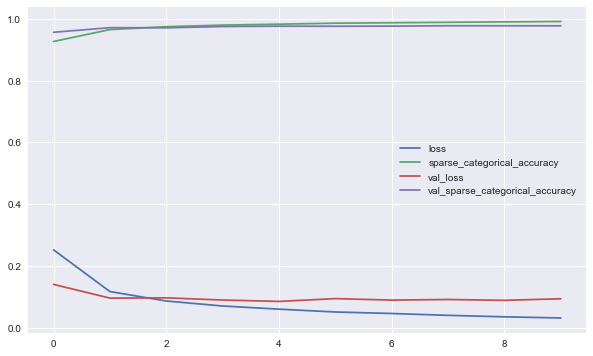

In [10]:
pd.DataFrame(history.history).plot(figsize=(10,6))

- With only one hidden layer we were able to have a test accuracy of 97.5%
- This is quite good, but we'll see soon how we can do even better (CNNs)!